# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is a classification problem. We have to use the data provided to try to identify different patterns between the students who passed the class and the students who failed it. In other words, the goal of the project is to be able to classify the students in two groups (pass versus fail) based on the data given previous to the final exam, this way we'll be able to have a good estimate on students that are having trouble with the class and might have a higher chance of failing the final exam.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# DONE: Calculate number of students
n_students = len(student_data)

# DONE: Calculate number of features
n_features = student_data.shape[1] - 1

# DONE: Calculate passing students
passed_binary = map(lambda x: int(x=='yes'), student_data.get('passed'))
n_passed = reduce(lambda x,y: x + y, passed_binary)

# DONE: Calculate failing students
n_failed = n_students - n_passed

# DONE: Calculate graduation rate
grad_rate = 100*n_passed*1./n_students

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


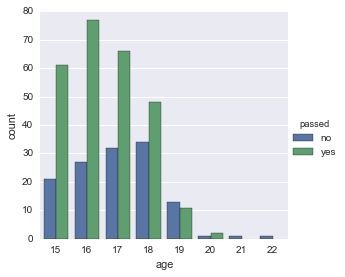

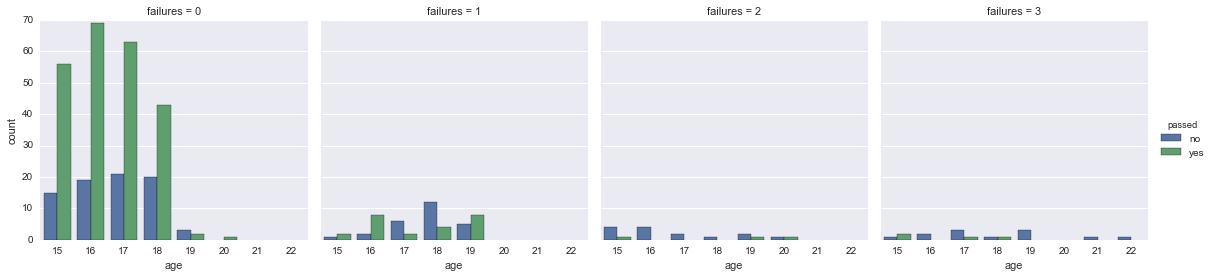

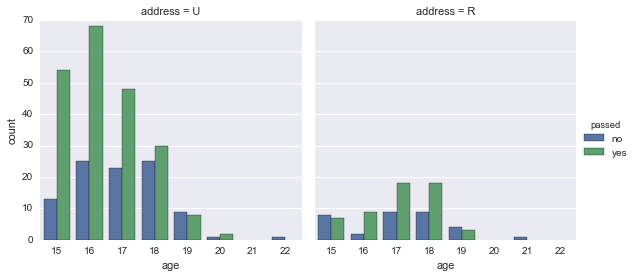

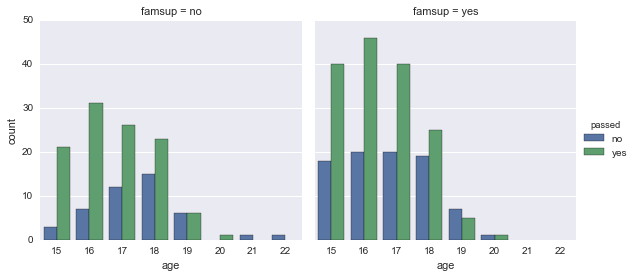

In [3]:
#Some additional Data Exploration
%matplotlib inline
import seaborn as sns
sns.factorplot("age", data=student_data, hue='passed', kind="count")
sns.factorplot("age", col="failures", data=student_data, hue='passed', kind="count")
sns.factorplot("age", col="address", data=student_data, hue='passed', kind="count")
sns.factorplot("age", col="famsup", data=student_data, hue='passed', kind="count")

The above graphs help us to better understand some of the features in the data and also to check if our intuition about the data is correct or not. It also helps us on analysing what models could be better suited for this particular data set. For example, I was trying to see if there was an obvius correlation between students passing and their ages, if they live in a rural or urban environment, if they have family support during classes and if they have previously failed in another class.

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# DONE: Import any additional functionality you may need here
from sklearn import cross_validation

# DONE: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# DONE: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, stratify=y_all, test_size=num_test, random_state=1)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [7]:
#The stratify parameter helps to guarantee similar proportions of yes and no target labels
print "Grad rates:\nTrain set = {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Test set = {:.2f}%".format(100 * (y_test == 'yes').mean())

Grad rates:
Train set = 67.00%
Test set = 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: ** 

1) Gaussian Naive Bayes (GaussianNB):
    - Real-world applications: text categorization (http://www.kamalnigam.com/papers/multinomial-aaaiws98.pdf; http://www.kamalnigam.com/papers/emcat-aaai98.pdf) and medical diagnosis (http://www.research.ibm.com/people/r/rish/papers/RC22230.pdf)
    - Strengths: Extremely fast, requires small amount of data to get good results, due to the assumption of conditional independence  between the data's features it is less prone to the curse of dimensionality
    - Weaknesses: the conditional independence assumption is generally false in real-world applications, therefore the model is a bad estimator (it outputs bad estimates for the probabilities of the events) and it also performs poorly when the dependencies among the features don't cancel each other out
    - Why this model: small amount of data available; looking at the features available, the conditional independence assumption seems fair (given the student, school, sex, age, job, etc, are fairly independent)
    
2) K-Nearest Neighbors (KNeighbors):
    - Real-world applications: handwritten digit recognition (http://ieeexplore.ieee.org/document/6755106/?reload=true), protein localization (http://www.aaai.org/Papers/ISMB/1997/ISMB97-022.pdf), satellite image processing (http://www.ijetae.com/files/Volume5Issue9/IJETAE_0915_21.pdf)
    - Strengths: easy to understand and implement, non-parametric (often successful in situations where the decision boundry is irregular)
    - Weaknesses: can be computationally expensive to predict unlabeled samples in a significantly big labeled data set, sensitive to the data structure, sensitive to the metric used in the definition of distance between the samples in the data set
    - Why this model: relatively small data set with a very likelly irregular decision boundry
    
3) Ensemble Methods (AdaBoost with Decision Trees):
    - Real-world applications: visual object detection (http://wearables.cc.gatech.edu/paper_of_week/viola01rapid.pdf)
    - Strengths: combine several weak learners to produce a strong one, empirical studies show that it often does not overfit, simplicity of implementation
    - Weaknesses: it has the same weaknesses from the base learning algorithm (in this case: decision trees)
    - Why this model: the problem looks like a good candidate for a decision tree model and using an ensemble method to boost the results is a great way to ensure the best performance of this kind of learning algorithm

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [8]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
# DONE: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

# DONE: Initialize the three models
clf_A = GaussianNB()
clf_B = KNeighborsClassifier()
clf_C = AdaBoostClassifier(random_state=1)

# DONE: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train
y_train_300 = y_train

# DONE: Execute the 'train_predict' function for each classifier and each training set size
print 'GaussianNB:\n'
train_predict(clf_A, X_train_100, y_train_100, X_test, y_test)
print '\n'
train_predict(clf_A, X_train_200, y_train_200, X_test, y_test)
print '\n'
train_predict(clf_A, X_train_300, y_train_300, X_test, y_test)
print '\n'

print 'K-Nearest Neighbors:\n'
train_predict(clf_B, X_train_100, y_train_100, X_test, y_test)
print '\n'
train_predict(clf_B, X_train_200, y_train_200, X_test, y_test)
print '\n'
train_predict(clf_B, X_train_300, y_train_300, X_test, y_test)
print '\n'

print 'AdaBoost:\n'
train_predict(clf_C, X_train_100, y_train_100, X_test, y_test)
print '\n'
train_predict(clf_C, X_train_200, y_train_200, X_test, y_test)
print '\n'
train_predict(clf_C, X_train_300, y_train_300, X_test, y_test)

GaussianNB:

Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.7966.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.6379.


Training a GaussianNB using a training set size of 200. . .
Trained model in 0.0000 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8148.
Made predictions in 0.0000 seconds.
F1 score for test set: 0.7344.


Training a GaussianNB using a training set size of 300. . .
Trained model in 0.0010 seconds
Made predictions in 0.0000 seconds.
F1 score for training set: 0.8190.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7500.


K-Nearest Neighbors:

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 0.0010 seconds
Made predictions in 0.0010 seconds.
F1 score for training set: 0.8085.
Made predictions in 0.0010 seconds.
F1 score for test set: 0.7050.


Training a KNeighborsClassi

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - GaussianNB**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.001           |          0.000         |      0.7966      |      0.6379     |
| 200               |         0.001           |          0.000         |      0.8148      |      0.7344     |
| 300               |         0.001           |          0.001         |      0.8190      |      0.7500     |

** Classifer 2 - KNeighborsClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.000           |         0.001          |      0.8085      |      0.7050     |
| 200               |         0.001           |         0.002          |      0.8571      |      0.7164     |
| 300               |         0.001           |         0.002          |      0.8546      |      0.7591     |

** Classifer 3 - AdaBoostClassifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |         0.121           |         0.005          |      0.9846      |      0.6560     |
| 200               |         0.102           |         0.005          |      0.8832      |      0.7007     |
| 300               |         0.101           |         0.005          |      0.8821      |      0.7536     |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: ** 

After seeing the results demonstraded in the above tables and also running more tests with diferent random states for the data, even though the GaussianNB model is the fastest one for training and predicting, it is the one with the worst performance (lowest F1 Score) in both the training and the testing set, therefore it's not a good choice for this data set.

Between the KNeighborsClassifier and the AdaBoostClassifier the difference lies mostly on the training time. The AdaBoostClassifier takes significantly longer to get trained, but it's performance (F1 Score) is practically the same as the KNeighborsClassifier. For bigger data sets, the longer training time might be an issue. Also, updating the KNeighborsClassifier with new data is extremely fast and it might keep improving the model's performance on predicting new data labels. With that being said, the best model between these 3 is the KNeighborsClassifier.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

The K-Nearest Neighbors algorithm works by comparing the information about a new student to the information of previous students who already passed or failed and trying to match the new student to the K more similar previous ones. One of the best qualities of this model is how fast it is to train it and to update it when a batch of new students graduates. To train or update the algorithm you simply have to store the information on past students to compare it to the new students afterwards. The training time of the model is based solely on how long it takes to sort the previous students to make it easier to spot similar students later. After that, a tool for quantifying and measuring the similarities between the students (like if they have the same sex, the same family size, etc.) is defined and, then, all it takes to make a prediction is finding the K most similar students in the sorted information and weight their chances to pass or fail to properly predict if a new student might or might not fail.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [10]:
# DONE: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
#Import Normalizer for standardizing the data
from sklearn.preprocessing import Normalizer

# DONE: Create the parameters list you wish to tune
parameters = {'n_neighbors':range(1,20), 'weights':['uniform','distance'], 'p':[1, 2]}

# DONE: Initialize the classifier
clf = KNeighborsClassifier()

# DONE: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# DONE: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=f1_scorer)

#Standardizing the Data
normer = Normalizer()
X_train = normer.fit_transform(X_train)
X_test = normer.transform(X_test)

# DONE: Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0080 seconds.
Tuned model has a training F1 score of 0.8298.
Made predictions in 0.0020 seconds.
Tuned model has a testing F1 score of 0.8267.


In [11]:
print clf.get_params()

{'n_neighbors': 17, 'n_jobs': 1, 'algorithm': 'auto', 'metric': 'minkowski', 'metric_params': None, 'p': 1, 'weights': 'uniform', 'leaf_size': 30}


In [12]:
print clf_B.get_params()

{'n_neighbors': 5, 'n_jobs': 1, 'algorithm': 'auto', 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'weights': 'uniform', 'leaf_size': 30}


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** 

Using GridSearchCV we were able to fine tune the following parameters of our KNeighborsClassifier:
- n_neighbors: aka K. This number determines the number of neighbors the model will look for similarities to make a prediction. We tried numbers ranging from 1 to 20;
- weights: this is related to how the model weights in the different similarities from the diferent neighbors. This value can either be 'uniform' (meaning all neighbors have equal weights) or 'distance' (meaning the neighbors get weighted by the inverse of their distance to the new data point, i.e. closer neighbors have bigger weights);
- p: this parameter is related to the metric that our model uses to determine the similarities (or the distance) between the data points. It can either be 1 (Manhattan Distance) or 2 (Euclidean Distance).

The final F1 Score we got was 0.8298 for the training data and 0.8267 for the testing data, with a model using 17 neighbors, uniform weights and the Manhattan Distance as the metric. For the testing data, that is higher than what the untuned model we ran first had: F1 Score of 0.7591, with 5 neighbors, uniform weights and the Euclidean Distance as the metric.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.